# BLU05 - Learning Notebook - Part 2 of 3 - SARIMAX

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import gauss
from random import seed
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)   
seed(1)
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import stattools
from pandas.plotting import lag_plot
from statsmodels.tsa.arima_model import ARIMA
import utils
from utils import load_airlines_series
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 4)

In [2]:
airlines = utils.load_airline_data()

Before going into modelling let's make the variance of our time series approximately stationary using log. As you learned in the previous notebook, to make the time series stationary we should also diff it to remove the trend. Here we're going to pass that step, because as you will see later the model can actually do that for us.

In [3]:
airlines_logged = np.log(airlines)

Now, like in any modelling problem, let's split the dataset into train and test to make sure we don't leak any information. Sometimes simply looking at the test set can give us intuition that we shouldn't have. Remember that the objective of evaluating a model is to obtain a good estimation of the generalization error the model will have to never before seen data. For that, we need to pretend we don't know there is a test dataset, and use it only at the end as a good estimation of the generalization error.

Also, in timeseries dataset splits need to be done taking into account the temporal nature of the data. Basically, this means that in a simple train-test split we leave the first X months for training and the last Y months for testing.

In [4]:
train = airlines_logged[:-24]
test = airlines_logged[-24:]

## 1. ARIMA 

[ARIMA](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMA.html) is one of the most used models for predicting timeseries. There are more sophisticated versions that we will get to later, but for now we'll use the plain vanilla version to develop some intuitions. 

ARIMA stands for: 

- (AR) Auto Regressive 
- (I)  Integrated 
- (MA) Moving Average

### 1.1 Hyperparameters

About the model API, it elegantly depends only on 3 parameters: 

> `ARIMA(p,d,q)`

Wondering what they mean?

- `p`: The number of auto-regressive terms. These are the lags of the dependent variable. Is the present point dependent on the previous one? On the previous two? Eight? 

- `d`: The "integrated" part of the name means we take the diff between consecutive periods to make the time series stationary. We've already done this ahead of time (because we needed it for our ACF and PACF plots), but you can also leave it as a hyper parameter and tune it later.*

- `q`: The number of moving average terms. The logic here is similar to the one we used for `p`, but instead of predicting values with lagged values, we are predicting errors with lagged errors. The MA terms are lagged forecast errors. In this model, what predicts `x(t)` is `e(t-1)`, `e(t-2)`, ..., where `e(i)` is the difference between the moving average at the ith instant and the actual value.

Theses hyperparameters will define the architecture (skeleton) of your model. The defined model will then be fitted to your dataset via maximum likelihood estimation. For a more thorough explanation of the math behind arima make sure to check this [article](https://people.duke.edu/~rnau/411arim.htm).

### 1.2 Hyperparameter Selection

And how do we choose them? The artisanal way to decide p and q is to use the table below. What is cutt off and tail off you ask? Cut off means there is an abrupt decrease to 0 after a certain lag. Tail off means the autocorrelation is slowly decreasing over time. This [stack exchange question](https://stats.stackexchange.com/questions/241914/terms-cut-off-and-tail-off-about-acf-pacf-functions) has an interesting discussion about it.

|      |         AR(p)        |         MA(q)        | ARMA(p,q) |
|:----:|:--------------------:|:--------------------:|:---------:|
|  ACF |       Tails off      | Cuts off after lag q | Tails off |
| PACF | Cuts off after lag p |       Tails off      | Tails off |

Let's calculate the PACF and ACF plots for our train dataset. Note that we added the `.diff().dropna()`, because these plots require the stationary time series. And remember that the first bar corresponds to lag 0, so it's is always 1.

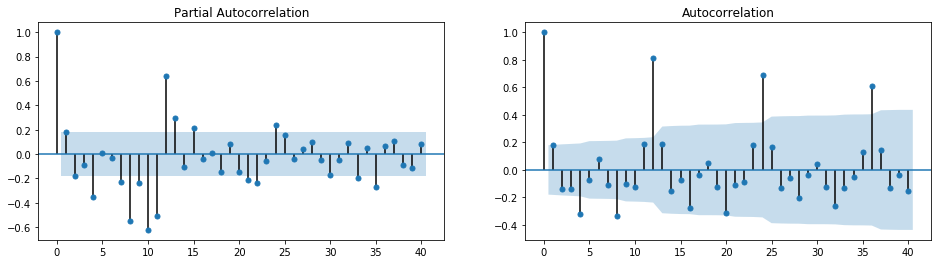

In [5]:
fig, ax = plt.subplots(1,2)
plot_pacf(train.diff().dropna(), alpha=.05, lags=40, ax=ax[0], method='ols')  
plot_acf(train.diff().dropna(), alpha=.05, lags=40, ax=ax[1])  
plt.show()

Our case doesn't seem like either a pure AR nor pure MA process because there's no clear tail off nor cut off. In this situation, the autocorrelation plots can't tell us how to choose the parameters. Get used to it, because this will happen in most cases.

If you search through the web you may find several rules of thumb to try and chose the parameters in these cases, but several will be contradictory, and at the end of the day the best approach is to use an automatic method, just like we do hyperparameter tuning in machine learning models. So, let's use some parameters that have been previously found by an automatic method. Don't worry, you will learn this soon ;)

### 1.3 Modelling

We will start by using our previously found parameters. Note that these parameteres were for our `train` dataset (the one that isn't diffed), that may explain why `d=1`. If we had used the diffed one, potentially we would get the same parameters but with `d=0`.

In [6]:
arima = SARIMAX(train, order=(2, 1, 1),trend='c') # these have been previously found via an automatic method
arima_results = arima.fit()
arima_predictions = np.exp(arima_results.predict())[1:] # grab the prediction from our model and undo the log transform using exp

In [7]:
print('Can this possibly return a... %s  OH MY GOD IT DID THAT IS SO AWESOME!!' % type(arima_predictions))

Can this possibly return a... <class 'pandas.core.series.Series'>  OH MY GOD IT DID THAT IS SO AWESOME!!


A few of things to note about the API:
1. We passed the data straight to the model (unlike in sklearn) 
3. We passed the order `(p, d, q)` as `(2, 1, 1)`.
4. We called `fit` without any parameters (which is also different from sklearn) 
5. The model isn't fit in place, we have to grab the results with a `arima_results`
6. The first value of the prediction is 0, this is because we don't have the lags needed to forecast it so the model outputs 0. We did `[1:]` to remove this value from our prediction.

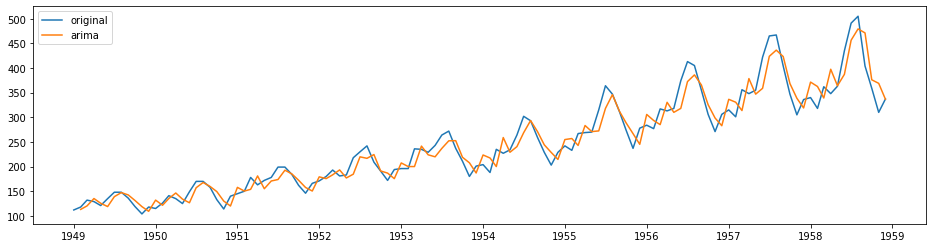

In [8]:
plt.plot(np.exp(train), label='original')
plt.plot(arima_predictions, label='arima')
plt.legend()

Hmm not too bad, but not perfect either. Also, there seems to be some seasonality in there that we're not taking into account with our current model. We'll have to use the SARIMAX!

## 2. SARIMAX

This is the SARIMAX. What does that stand for? 

![](https://i.imgflip.com/2ab2xu.jpg)

The **Autoregressive Integrated Moving Average** part we already know. _(well... kind of anyway)_ 

Now what about the new bits? 

- **`Seasonal`**: as the name suggests, this model can actually deal with seasonality. Coool.... 
- **`With Exogenous`** roughly means we can add external information. For instance we can include the temperature time series to predict the ice cream sales, which is surely useful. Exogenous variables are explained better in next learning notebook.

In terms of parameters, we have  
- `p`, `d` and `q`: These are the same as before.
- `P`, `D` and `Q`: These are analagous to the previous ones, but refer to the seasonal part of the time series.
- `S`: an integer giving the periodicity (number of periods in season). If we have daily data and suspect we may have weekly trends, we may want `S` to be 7. If the data is monthly and we think the time of the year may count, maybe try `S` at 12 

Of course that to understand better these parameters you should take a closer look at [the documentation](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html).

But how do we chose them? Well, `S` is quite intuitive, looking at the ACF we can see strong correlation with lag 12, 24, 36, etc. thus indicating yearly seasonality! Hence `S = 12`. Regarding `P`, `D` and `Q` it's even less intuitive than our previous ones, so we'll just use some pre defined ones. Remember that at the end of the day we will use an automatic method to chose this, just like we do with machine learning models.

In [9]:
sarimax = SARIMAX(train,     trend='c',        
                          order=(2, 0, 0),              # <-- keeping same params as before
                          seasonal_order=(0, 1, 1, 12)) # <-- We'll get into how we found these hyper params later
sarimax_results = sarimax.fit(maxiter=1000)
sarimax_predictions = np.exp(sarimax_results.predict())[24:] # grab the prediction from our model and undo the log transform using exp

Done. Seriously, check this out: 

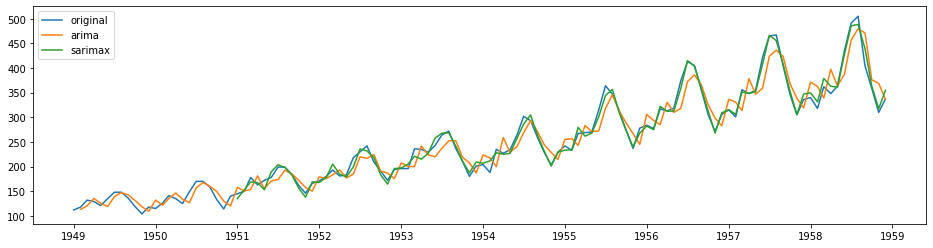

In [10]:
plt.plot(np.exp(train), label='original')
plt.plot(arima_predictions, label='arima')
plt.plot(sarimax_predictions, label='sarimax')
plt.legend()

From the plot, SARIMAX clearly looks better, but how can we quantify this?

### 2.1 In-Sample Evaluation

The standard metric for timeseries classical models is the AIC (Akaike information criterion), which is a metric that will simutaneously measure how well the model fits the data, but will control for how complex the model is. If the model is very complex, the expectation on how well it must fit the data will also go up. It is therefore useful for comparing models. 

If you (for some weird reason) feel compelled to calculate it by hand, [this post](https://stats.stackexchange.com/questions/87345/calculating-aic-by-hand-in-r?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa) explains how to do so. Then again, it's sunny and beautiful outside, and Statsmodel has got your back. 


In [11]:
arima_results.aic

-224.5387533012135

In [12]:
sarimax_results.aic

-393.53673097146213

Smaller is better, so the more negative the better. It's clear that our SARIMAX is significantly better than our ARIMA model, just like the plot hinted.

You may already be thinking that using AIC we can compare different models, perhaps that's how we got to those magical hyper parameters...?

Well SARIMAX seems to be significantly better than the ARIMA! But you're probably thinking: We're just looking at how well each of the model fits the train dataset, not how well it generalizes. And you would be correct! Let's look into actually forecasting with our models.

## 3. Forecasting

Previously we used `get_prediction()` to get in-sample predictions. Now we need to use `get_forecast()` to get out-of-samples. Also note that in time series nomenclature, it's common to call predictions to in-sample predictions and forecasts for out-of-sample predictions.

**PS:** on the `get_prediction()` method there is a dynamic parameter which is supposed to simulate a forecast. **Do not use this**. This makes an inference that only uses the labels until a certain point, and from then on makes a multi-step forecast. The problem is that this model has previously been fited with the whole dataset. This means you are training the model on the whole dataset, and then forecasting an interval within this dataset. This is a clear case of data leakage and there is no situation in which you should use this, always go for the method below.

### 3.1 Individual Forecast

The get predictions we used is only for in sample predictions. For inference we use `get_forecast()`. An important distinction in time series forecasting is between one-step forecasting and multi-step forecasting. But it's actually quite simple, the first means we're just predicting the next step, the second means we're predicintg multiple steps. Using the `get_forecast()` method we can specify how many steps we want.

In [13]:
arima_forecast = arima_results.get_forecast(24)

In [14]:
sarimax_forecast = sarimax_results.get_forecast(24)

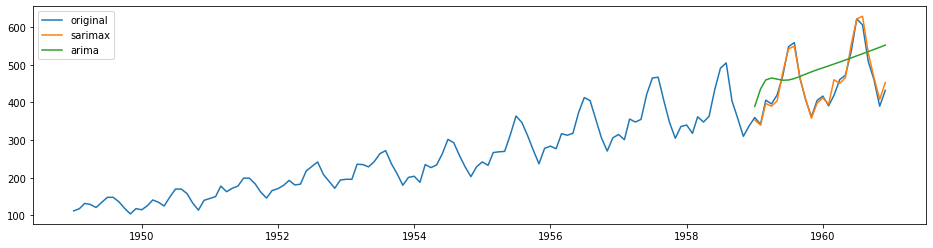

In [15]:
plt.plot(airlines, label='original')
plt.plot(np.exp(sarimax_forecast.predicted_mean), label='sarimax')
plt.plot(np.exp(arima_forecast.predicted_mean), label='arima')
plt.legend()

Great! But these are just the forecasts that would have been made at time `t=1959-11-30`, which is the last sample in our train set. What if we want to validate how well our model would have performed during the entire test set? As in, performing a new forecast on each month.

### 3.2 Multiple Forecasts

For the one-step forecast it's trivial that if we want to forecast `1960-01-31`, we need data from `1959-12-31`. But for the multi-step forecast this isn't as trivial, so it makes sense to discuss it. Imagine we're already in `1959-12-31` and we have the corresponding data, it would make sense to give this information to our model to update it's multi-step forecast. The multi-step forecasts made in `1959-12-31` should be better than the one made in `1959-11-30` (this doesn't always happen, but there's motivation to use the most recent data). How can we do this? There's two main options:

- **Static Model:** This means we mantain the same model, meaning the same hyperparameters (p,d,q,P,D,Q,S) and the same parameters (the ones estimated during the train set fitting). We simply change the starting point of the forecast to the new sample of data we feed the model.
- **Dynamic Model:** This means we're going to make use of the new sample of the data to actually change our model. We can do this three ways:
    - **Refit:** Here we're going to mantain the model hyperparameters, but we'll retrain the model using the new data.
    - **Remake:** Here we're going to remake the model, meaning we will find the hyperparameters again and make a new fitting.
    
Having so many options may seem daunting, but if you think about it it's quite simple and seamlessly translates to how you mantain machine learning models. From static model, to refitting, to remaking, we're going from a more conservative to a more reactive approach to model maintenance. Being more reactive means giving more weight to new data, but also having more work because you will change your model and that may require some validations to make sure everything's working as it should. In practice, what should be done depends on the specifics of the project. For monthly forecasts like this, you probably don't want to mantain a static model, you're quite confident you can update it. But you probably also don't want to remake the model every month. If you're interested in learning more about this check [statmodels documentation on it](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_forecasting.html).

Let's see how we can do all these approaches in statsmodels. We will only look at multiple forecasts for the one-step case, which is equivalent to the multi-step with step equal to 1.

In [16]:
# This may take a minute or two to run. Go grab a coffee ;) 

sarimax_forecast_one_step_static = []
sarimax_forecast_one_step_refit = []

sarimax_results_static = sarimax_results
sarimax_results_refit = sarimax_results

for i in np.arange(0,24):
    # Static Forecast
    next_step_forecast = sarimax_results_static.get_forecast().predicted_mean[0]
    sarimax_forecast_one_step_static.append(next_step_forecast)
    sarimax_results_static = sarimax_results_static.append(test[i:i+1])
    
    # Refit Forecast
    next_step_forecast = sarimax_results_refit.get_forecast().predicted_mean[0]
    sarimax_forecast_one_step_refit.append(next_step_forecast)
    sarimax_results_refit = sarimax_results_refit.append(test[i:i+1], refit=True,
                                                         fit_kwargs={'method':'nm', 'maxiter':1000,'disp':False})

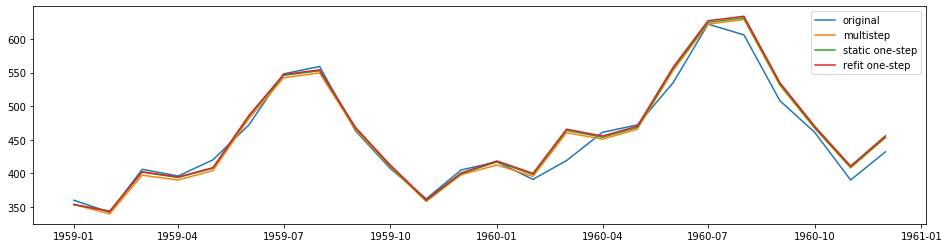

In [17]:
plt.plot(airlines[-24:], label='original') # Removed part of the observations to highlight model differences
plt.plot(np.exp(sarimax_forecast.predicted_mean), label='multistep')
plt.plot(test.index,np.exp(sarimax_forecast_one_step_static), label='static one-step')
plt.plot(test.index,np.exp(sarimax_forecast_one_step_refit), label='refit one-step')
plt.legend()

All of them seem quite similar! It seems we need to start quantifying the performance to distinguish between similar models.

## 4. Out-of-Sample Evaluation

Even though for validation and hyper parameter optimisation it's common to use AIC, the truth is that in real world projects you (and your customers) will care about more common metrics such as the MAE or MSE, since these are much more interpretable and can be calculated independently of the models.

Let's calculate the MAE for our three forecasts:

In [18]:
mean_absolute_error(np.exp(sarimax_forecast.predicted_mean),np.exp(test))

10.62078098295826

In [19]:
mean_absolute_error(np.exp(sarimax_forecast_one_step_static),np.exp(test))

10.420898674537879

In [20]:
mean_absolute_error(np.exp(sarimax_forecast_one_step_refit),np.exp(test))

10.924932959853207

Ok, the best forecast is the one-step forecast from the static model, which makes sense. But the next two are quite surprising! It seems the multi-step forecast actually performed better than the one step forecast with refit! This means that a model with no knowledge of the following 24 months performed better than a model which always had information regarding the previous month. Let's try to understand a bit better why this happens.

### 4.1 Error Analysis

To understand the performance of each model over time, let's calculate the cumulative MAE:

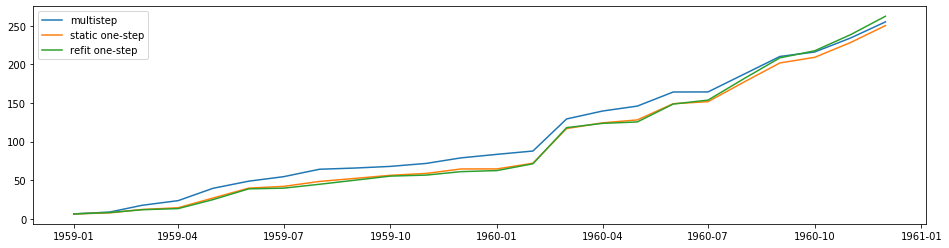

In [21]:
plt.plot(test.index, np.abs(np.exp(sarimax_forecast.predicted_mean)-airlines[120:]).cumsum(), label='multistep')
plt.plot(test.index,np.abs(np.exp(sarimax_forecast_one_step_static)-airlines[120:]).cumsum(), label='static one-step')
plt.plot(test.index,np.abs(np.exp(sarimax_forecast_one_step_refit)-airlines[120:]).cumsum(), label='refit one-step')
plt.legend()

Well this is interesting. It seems the multistep model was performing worse (bigger MAE) during most of the time, but in 1960 after July the patterns changes. If we check on the time series plot above, we can see that it's exactly in August of 1960 that all models make a significant error on the prediction. All the models predicted an increase, but the actual values actually decreased, and it so happened that the multistep was a bit closer to the real values compared to the one-step refitted one. At the end of the day when there are distribution changes there will always be some randomness involved.

I bet you're wondering how we actually chose the hyperparameters for the SARIMAX, right? Proceed to the next notebook to find out.